In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [39]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [40]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9605 files belonging to 2 classes.


In [41]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

In [42]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [43]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1000 files belonging to 2 classes.


In [44]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [45]:
len(train_ds)

270

In [46]:
len(val_ds)

30

In [47]:
len(test_ds)

32

In [48]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [50]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])

In [51]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
import tensorflow as tf
from tensorflow.keras import models, layers
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Add dropout layer after the first convolutional layer
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Add dropout layer after the third convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Add dropout layer after the last convolutional layer
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout layer after the dense layer
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [53]:
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_42 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (32, 127, 127, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [54]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/5
270/270 [==============================] - 1642s 5s/step - loss: 0.5504 - accuracy: 0.7170 - val_loss: 0.4790 - val_accuracy: 0.7728
Epoch 2/5
270/270 [==============================] - 739s 3s/step - loss: 0.4102 - accuracy: 0.8226 - val_loss: 0.5262 - val_accuracy: 0.6956
Epoch 3/5
270/270 [==============================] - 713s 3s/step - loss: 0.3668 - accuracy: 0.8377 - val_loss: 0.3684 - val_accuracy: 0.8596
Epoch 4/5
270/270 [==============================] - 787s 3s/step - loss: 0.3455 - accuracy: 0.8553 - val_loss: 0.3499 - val_accuracy: 0.8574
Epoch 5/5
270/270 [==============================] - 689s 3s/step - loss: 0.3291 - accuracy: 0.8619 - val_loss: 0.3065 - val_accuracy: 0.8778


In [56]:
model_version = 1
model.save(r"C:\Users\frede\\melanoma_cancer_dataset\model\1")

INFO:tensorflow:Assets written to: C:\Users\frede\\melanoma_cancer_dataset\model\1\assets


INFO:tensorflow:Assets written to: C:\Users\frede\\melanoma_cancer_dataset\model\1\assets


In [57]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 75s 370ms/step - loss: 0.2660 - accuracy: 0.8910


In [58]:
scores

[0.26600590348243713, 0.890999972820282]

In [59]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 270}

In [60]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
type(history.history['loss'])


list

In [62]:
len(history.history['accuracy'])



5

In [63]:
history.history['val_accuracy']

[0.7727760076522827,
 0.6956055760383606,
 0.8595927357673645,
 0.8574491143226624,
 0.8778135180473328]

In [64]:
history.history['loss'][:5]

[0.5503975749015808,
 0.41018015146255493,
 0.3668082654476166,
 0.34546613693237305,
 0.32908961176872253]

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


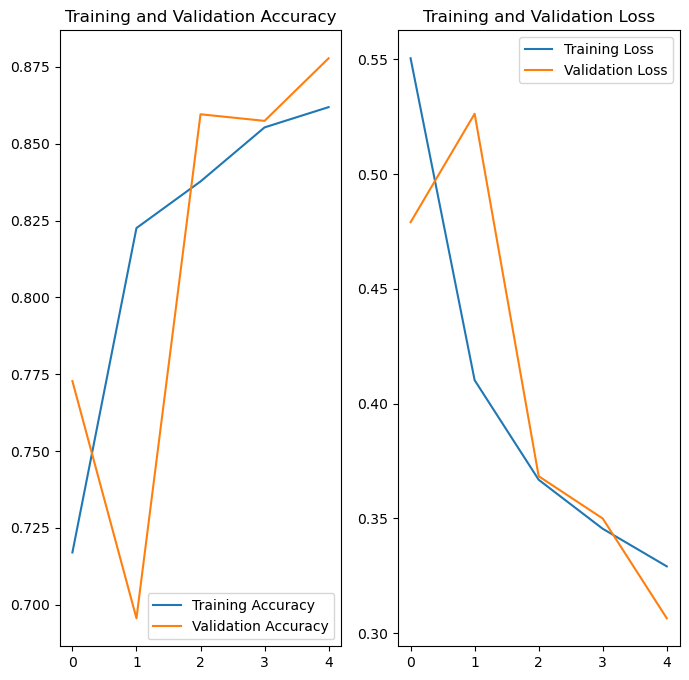

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: benign
1/1 [==============================] - 2s 2s/step
predicted label: benign


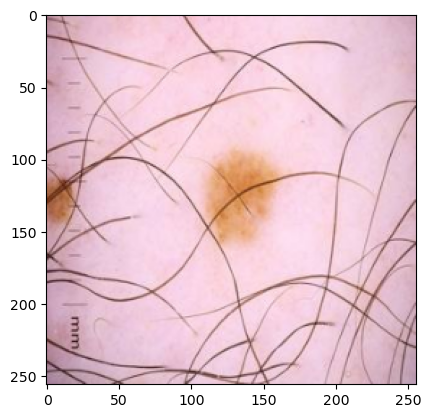

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


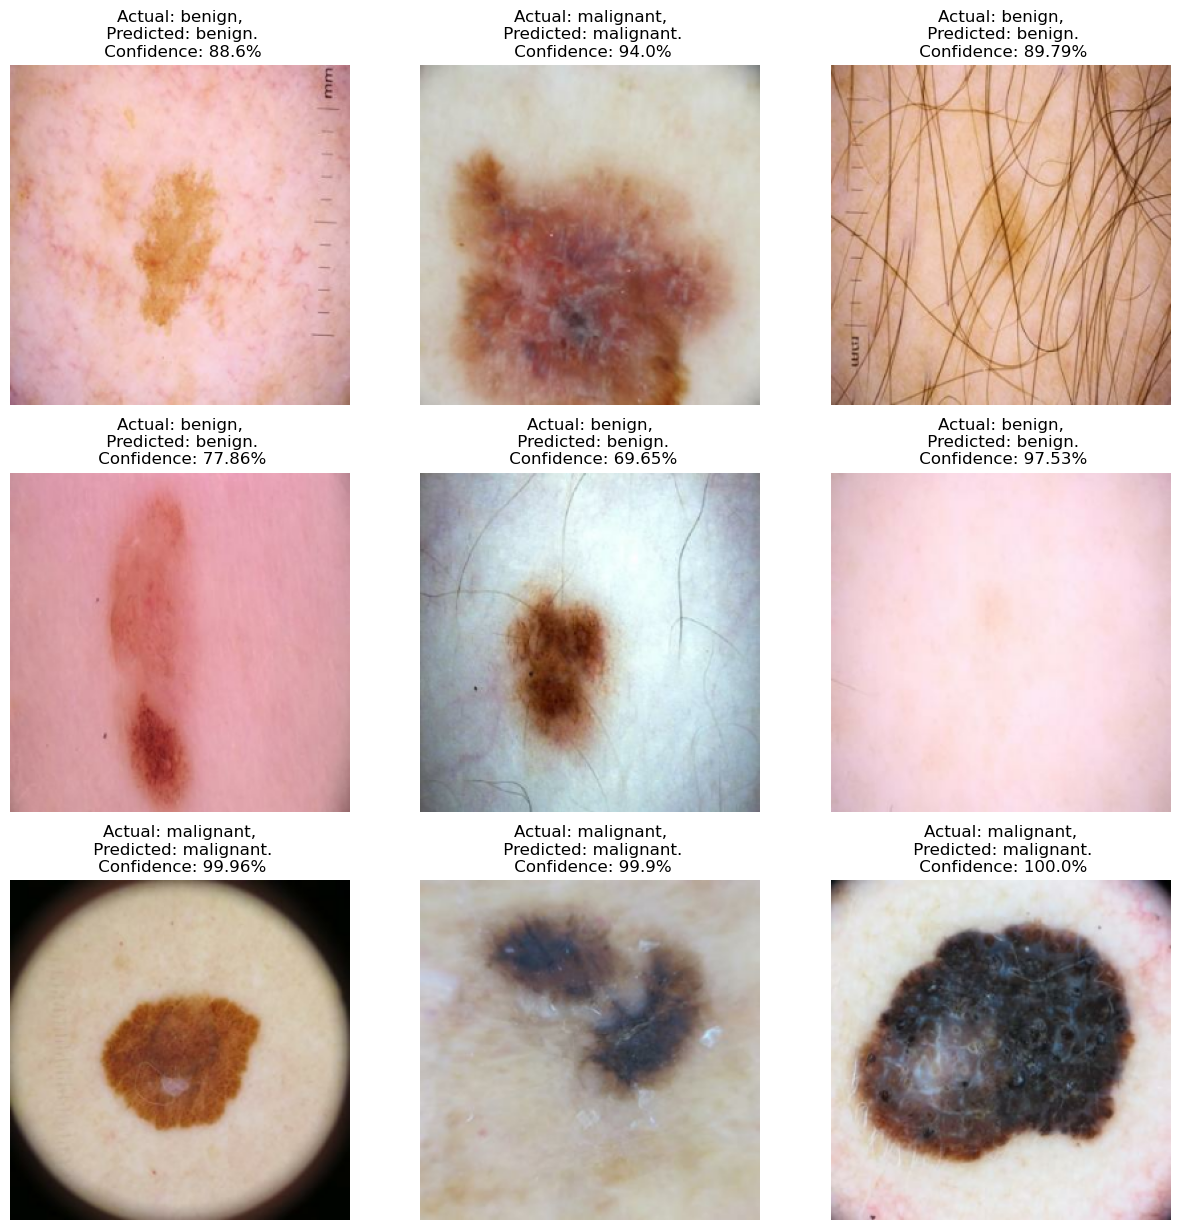

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [72]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


model = tf.keras.models.load_model(r"C:\Users\frede\\melanoma_cancer_dataset\model\1")


class_names = ['benign', 'malignant']


benign =r"C:\Users\frede\melanoma_cancer_dataset\test\benign"

malignant =r"C:\Users\frede\melanoma_cancer_dataset\test\malignant"

max_iterations=10
def classificator(image_dirteste,actual_class,max_iterations):
    
    iteration_count = 0  
    image_dirteste = image_dirteste
    result_list = []  
    
    for filename in os.listdir(image_dirteste):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dirteste, filename)

            predicted_class, confidence = predict(model, image_path, class_names)
            result_list.append({'File Name': filename,
                                'Predicted Label': predicted_class,
                                'Actual Label': actual_class})

            iteration_count += 1

            if iteration_count >= max_iterations:
                break
    
    return result_list

In [85]:
benign_list = classificator(benign,'benign',10000)

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


In [86]:
import pandas as pd

df_benign = pd.DataFrame(benign_list)

In [87]:
df_benign

,File Name,Predicted Label,Actual Label
0,melanoma_10000.jpg,benign,benign
1,melanoma_10001.jpg,benign,benign
2,melanoma_10002.jpg,benign,benign
3,melanoma_10003.jpg,benign,benign
4,melanoma_10004.jpg,benign,benign
...,...,...,...
495,melanoma_9995.jpg,benign,benign
496,melanoma_9996.jpg,benign,benign
497,melanoma_9997.jpg,benign,benign
498,melanoma_9998.jpg,benign,benign


In [88]:
malignant_list=classificator(malignant,'malignant',10000)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


In [89]:
df_malignant = pd.DataFrame(malignant_list)

In [124]:
from IPython.display import display


display(df_malignant)

,File Name,Predicted Label,Actual Label
0,melanoma_10105.jpg,malignant,malignant
1,melanoma_10106.jpg,benign,malignant
2,melanoma_10107.jpg,benign,malignant
3,melanoma_10108.jpg,benign,malignant
4,melanoma_10109.jpg,benign,malignant
...,...,...,...
495,melanoma_10600.jpg,malignant,malignant
496,melanoma_10601.jpg,malignant,malignant
497,melanoma_10602.jpg,benign,malignant
498,melanoma_10603.jpg,malignant,malignant


In [112]:
df_malignant.describe()


,File Name,Predicted Label,Actual Label
count,500,500,500
unique,500,2,1
top,melanoma_10105.jpg,malignant,malignant
freq,1,427,500


In [113]:
df_benign.describe()

,File Name,Predicted Label,Actual Label
count,500,500,500
unique,500,2,1
top,melanoma_10000.jpg,benign,benign
freq,1,464,500


In [93]:
count_malignant = df_benign['Predicted Label'].value_counts()['malignant']
print(count_malignant)

36


In [115]:
count_malignant1 = df_malignant['Predicted Label'].value_counts()['malignant']
print(count_malignant)

427


In [126]:
#o modelo apresentou taxa de acerto médio de 89%
#com mais épocas e ajustes no modelo a precisão deve melhorar